In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from sklearn.model_selection import cross_validate, cross_val_score
from math import pi
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import pickle

In [320]:
# 0. Load Data and Drop Duplicates
data = pd.read_csv('../raw_data/datos.csv', delimiter = ';', low_memory = False)
data.drop_duplicates(inplace = True)
outliers = data.query('duracion_baja >= 100')  # Save outliers for analysis.
data = data.query('duracion_baja < 100')
# data.drop_duplicates(inplace = True)

# 1. Handle Null Values
# CNAE (only 482)
data = data.query('cnae != 0')

# CodiPostal (Most Frequent)
data['codipostal'] = data['codipostal'].replace('-', (data['codipostal']).mode()[0])

# Contracte (Delete few wrongs and then Most Frequent)
data = data[data['contracte'] != '001']
data = data[data['contracte'] != '019']
data = data[data['contracte'] != '999']

mf_contracte = data['contracte'].mode()[0]
data['contracte'] = data['contracte'].replace('000', mf_contracte).replace('-', mf_contracte)

# Grupcoti (Most Frequent)
mf_grupcoti = data['grupcoti'].mode()[0]
data['grupcoti'] = data['grupcoti'].replace('-', mf_grupcoti).replace('0', mf_grupcoti)

# 2. Data Cleaning
# ContadorBajasCCC (non-sense)
data.drop('ContadorBajasCCC', axis = 1, inplace = True)

# ContadorBajasDNI vs ContadordiasBajasDNI
data = data.query('ContadorBajasDNI <= ContadordiasBajasDNI')

# Categorize CNAE
c = pd.read_excel('Tabla_cnae.xlsx', usecols = ['GRUPO', 'COD_CNAE2009'])
c.rename(columns = {'GRUPO': 'cnae_cat', 'COD_CNAE2009': 'cnae'}, inplace = True)
c['cnae_cat'] = c['cnae_cat'].map(lambda x: ord(x) - 64)
c = c.query('cnae.str.isnumeric()').astype('int')
data = data.merge(c, how = 'left', on = 'cnae')

# Sickness Types
block_ends = [140,240,280,290,320,390,460,520,580,630,680,710,740,760,780,800,1000]
blocks = [[i+1, s] for i, s in enumerate(block_ends)]
special_cases = ['E','V','M']

def make_icd9_cat(row):
    first_str = row.icd9[0]
    if first_str == 'E':
        return 18
    if first_str == 'V':
        return 19
    if first_str == 'M':
        return 20
    else:
        code = float(row.icd9)
        for block in blocks:
            if code < block[1]:
                return block[0]
data['icd9_cat'] = data.apply(lambda row: make_icd9_cat(row), axis=1)

# Sickness Wrong Values
data = data.query('sexo != 1 | icd9_cat != 11')
data = data[~((data['sexo'] == 1) & (data['icd9'].str[:2].isin(['61', '62'])))]
data = data[~((data['sexo'] == 2) & (data['icd9'].str[:2] == '60'))]

# Post Code Categories.
data['codipostal_cat'] = data['codipostal'].str[:2]

# Time in company
# Add 0.01 to have the upper limit. (0.00 means up to 3 days)
data['proporcion_baja'] = (data['duracion_baja'] / (365 * (data['tiempo_en_empresa'] + 0.01)))
by_wrong_proportion = data.sort_values(by = 'proporcion_baja', axis = 0, ascending = False)
data = data.query('proporcion_baja <= 1')
data.drop('proporcion_baja', axis = 1, inplace = True)

# Month not required
data.drop('mes_baja', axis = 1, inplace = True)

# Cyclic Calendar
# data['time'] = (2 * pi * (data['epiweek'] - 1) + ((data['diasemana'] - 1) / 7)) / 52
# data['sin_time'] = np.sin(data['time'])
# data['cos_time'] = np.cos(data['time'])
# data.drop(['time', 'diasemana', 'epiweek'], axis = 1, inplace = True)

# 3. Prepare Data for ML
data.drop(['cnae', 'icd9', 'codipostal', 'contracte'], axis = 1, inplace = True)



/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [317]:
data

,ContadorBajasDNI,sexo,recaida,numtreb,ContadordiasBajasDNI,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,duracion_baja,epiweek,cnae_cat,icd9_cat,codipostal_cat
0,30,2,0,3187,224,2,0,7,0.51,27.2,2,51,8,1,08
1,5,2,0,3187,12,2,0,4,1.41,31.8,1,52,8,16,39
2,17,2,0,3187,46,2,0,4,0.54,20.5,1,52,8,8,38
3,16,2,0,3187,49,2,0,4,2.53,30.6,3,52,8,8,08
4,7,1,0,3187,548,1,0,5,6.16,32.4,2,52,8,8,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231012,9,2,0,8,21,10,0,7,1.99,44.9,1,53,14,16,08
231013,13,2,0,0,223,7,1,7,9.68,45.1,1,53,18,9,08
231014,13,2,0,0,223,8,1,7,3.75,45.1,1,53,9,9,08
231015,1,2,0,1,1,8,0,7,4.26,36.5,1,53,20,1,08


In [318]:
data[(data['ContadorBajasDNI']>25)].count() + data[(data['numtreb']>3200)].count() + data[(data['ContadordiasBajasDNI']>750)].count()

ContadorBajasDNI        3409
sexo                    3409
recaida                 3409
numtreb                 3409
ContadordiasBajasDNI    3409
grupcoti                3409
pluriempleo             3409
diasemana               3409
tiempo_en_empresa       3409
edad                    3409
duracion_baja           3409
epiweek                 3409
cnae_cat                3409
icd9_cat                3409
codipostal_cat          3409
dtype: int64

In [321]:
data.drop(data[(data['ContadorBajasDNI']>25)].index, axis = 0, inplace = True)
data.drop(data[(data['numtreb']>3200)].index, axis = 0, inplace = True)
data.drop(data[(data['ContadordiasBajasDNI']>750)].index, axis = 0, inplace = True)

In [322]:
sample = data.sample(n = 40000, random_state = 8)

In [325]:
sample

,ContadorBajasDNI,sexo,recaida,numtreb,ContadordiasBajasDNI,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,duracion_baja,epiweek,cnae_cat,icd9_cat,codipostal_cat
92385,2,2,0,63,2,7,0,4,1.52,30.0,37,10,3,10,25
188227,2,2,0,2,52,5,0,5,12.79,51.1,3,5,7,8,08
160076,1,2,0,8,1,7,0,5,0.03,20.3,2,7,14,8,46
214550,5,2,0,10,19,7,0,4,14.58,49.6,32,15,7,9,08
109145,1,1,0,62,1,9,0,5,2.63,59.5,2,3,3,8,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216823,19,1,0,61,286,9,0,5,4.65,41.2,2,17,3,16,08
46348,1,2,0,44,1,10,0,2,0.35,17.9,1,45,15,8,08
47623,2,1,0,210,6,8,0,2,4.20,44.3,33,40,3,13,08
131867,8,2,0,11,137,5,0,7,14.05,48.4,24,29,16,16,28


In [328]:

X_train, X_test, y_train, y_test = train_test_split(
                        sample.drop('duracion_baja', axis = 1), sample['duracion_baja'], test_size=0.3)

def prepare_data(X_train, X_test):
    # One hot Encode Categorical Features.
    ohe_cols = ['sexo', 'recaida', 'grupcoti', 'pluriempleo',
                'cnae_cat', 'icd9_cat', 'codipostal_cat']
    for col in ohe_cols:
        ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
        ohe.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[ohe.get_feature_names_out()] = ohe.transform(X_t[[col]])
            X_t.drop(col, axis = 1, inplace = True)


    # Scale numerical features.
    robust_cols = ['ContadorBajasDNI', 'ContadordiasBajasDNI', 'numtreb', 'tiempo_en_empresa']
    for col in robust_cols:
        rb_scaler = RobustScaler()
        rb_scaler.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[col] = rb_scaler.transform(X_t[[col]])

    standard_cols = ['edad', 'diasemana', 'epiweek']
    for col in standard_cols:   
        st_scaler = StandardScaler()
        st_scaler.fit(X_train[[col]])
        for X_t in [X_train, X_test]:
            X_t[col] = st_scaler.transform(X_t[[col]])
        

    return X_train, X_test

In [329]:
X_train_p, X_test_p = prepare_data(X_train, X_test)

In [330]:
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

In [331]:
model_LR_1 = LinearRegression()
cv_results_LR_1 = cross_validate(model_LR_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
LR_val_rmse = np.exp(cv_results_LR_1['test_neg_root_mean_squared_error'].mean()*(-1))
LR_val_r2 = cv_results_LR_1['test_r2'].mean()

model_LR_1.fit(X_train_p, y_log_train)
y_pred_LR_1 = model_LR_1.predict(X_test_p)
LR_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_LR_1, squared = False))

print(f'Validation R2= {np.round(LR_val_r2, 2)}, validation rmse= {np.round(LR_val_rmse, 2)}, and training rmse= {np.round(LR_train_rmse, 2)}')

/var/folders/jt/ljcpcwg95nv566n6vzs4822m0000gn/T/ipykernel_4572/1667108410.py:9: RuntimeWarning: overflow encountered in exp
  LR_val_rmse = np.exp(cv_results_LR_1['test_neg_root_mean_squared_error'].mean()*(-1))


Validation R2= -91513511177238.84, validation rmse= inf, and training rmse= 3.08


In [332]:
model_SGD_1 = SGDRegressor(loss='squared_error', alpha = 0.0001, max_iter = 1000, learning_rate = "invscaling", eta0 = 0.01)
cv_results_SGD_1 = cross_validate(model_SGD_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
SGD_val_rmse = np.exp(cv_results_SGD_1['test_neg_root_mean_squared_error'].mean()*(-1))
SGD_val_r2 = cv_results_SGD_1['test_r2'].mean()

model_SGD_1.fit(X_train_p, y_log_train)
y_pred_SGD_1 = model_SGD_1.predict(X_test_p)
SGD_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_SGD_1, squared = False))

print(f'Validation R2= {np.round(SGD_val_r2, 2)}, validation rmse= {np.round(SGD_val_rmse, 2)}, and training rmse= {np.round(SGD_train_rmse, 2)}')

Validation R2= 0.27, validation rmse= 3.08, and training rmse= 3.09


In [333]:
model_RF_1 = RandomForestRegressor(n_estimators=  750, min_samples_leaf= 4, min_samples_split= 10, n_jobs= -1, random_state=0)

In [334]:
cv_results_RF_1 = cross_validate(model_RF_1, X_train_p, y_log_train, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse = np.exp(cv_results_RF_1['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2 = cv_results_RF_1['test_r2'].mean()

model_RF_1.fit(X_train_p, y_log_train)
y_pred_RF = model_RF_1.predict(X_test_p)
RF_test_rmse = np.exp(mean_squared_error(y_log_test, y_pred_RF, squared = False))

print(f'Validation R2= {np.round(RF_val_r2, 2)}, validation rmse= {np.round(RF_val_rmse, 2)}, and testing rmse= {np.round(RF_test_rmse, 2)}')

Validation R2= 0.31, validation rmse= 2.98, and training rmse= 2.95


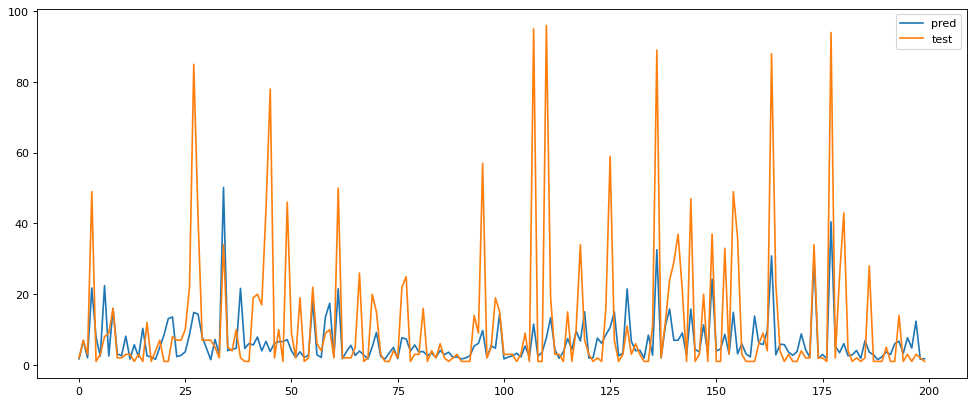

In [335]:
figure(figsize=(15, 6), dpi=80)
plt.plot(np.exp(y_pred_RF[1000:1200]), label = 'pred')
plt.plot(np.array(y_test)[1000:1200], label = 'test')
plt.legend()

In [338]:
model_xgb_1 = xgb.XGBRegressor(booster= 'dart', objective ='reg:squarederror', n_estimators = 750, learning_rate= 0.01,
                               min_child_weight= 4, max_depth= 8, colsample_bytree= 0.7, n_jobs=-1)

In [339]:
# XGB_val_r2 = cross_val_score(model_xgb_1, X_train_p, y_log_train, scoring='r2', cv=5).mean()
# XGB_val_rmse = cross_val_score(model_xgb_1, X_train_p, y_log_train, scoring='neg_root_mean_squared_error', cv=5).mean()*(-1)

model_xgb_1.fit(X_train_p, y_log_train)
y_pred_xgb = model_xgb_1.predict(X_test_p)
# XGB_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_xgb, squared = False))

# print(f'Validation R2= {np.round(XGB_val_r2, 2)}, validation rmse= {np.round(XGB_val_rmse, 2)}, and training rmse= {np.round(XGB_train_rmse, 2)}')
model_xgb_1.score(X_test_p, y_log_test)

0.330691759415193

In [340]:
y_pred_xgb = model_xgb_1.predict(X_test_p)

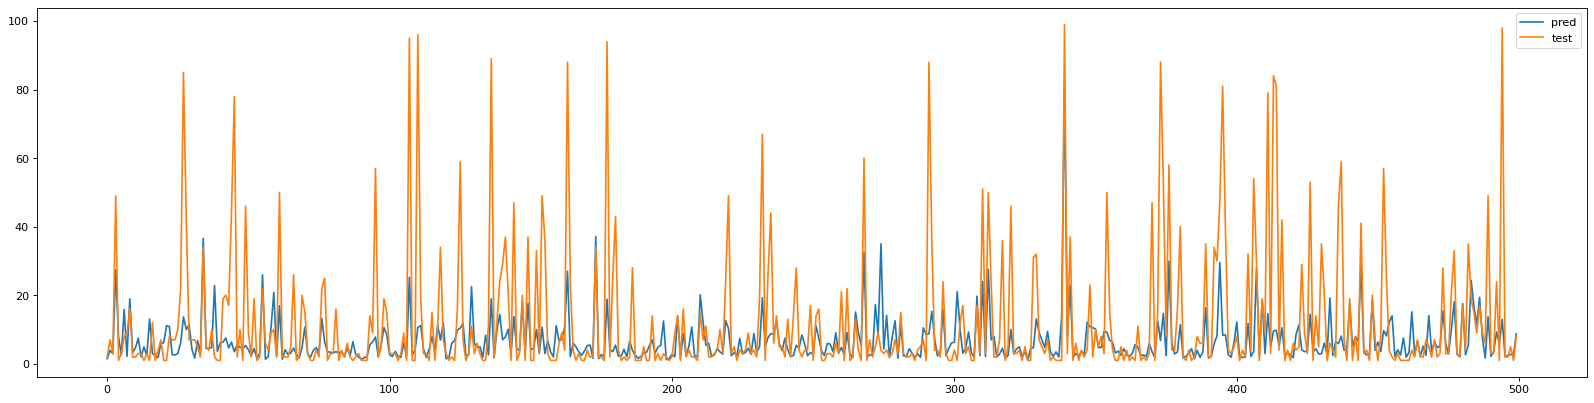

In [345]:
figure(figsize=(25, 6), dpi=80)
plt.plot(np.exp(y_pred_xgb[1000:1500]), label = 'pred')
plt.plot(np.array(y_test)[1000:1500], label = 'test')
plt.legend()

In [50]:
model_KNR_1 = KNeighborsRegressor(n_neighbors = 20, leaf_size = 40)
cv_results_KNR_1 = cross_validate(model_KNR_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
)

KNR_val_rmse = np.exp(cv_results_KNR_1['test_neg_root_mean_squared_error'].mean()*(-1))
KNR_val_r2 = cv_results_KNR_1['test_r2'].mean()

model_KNR_1.fit(X_train_p, y_log_train)
y_pred_KNR_1 = model_KNR_1.predict(X_test_p)
KNR_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_KNR_1, squared = False))

print(f'Validation R2= {np.round(KNR_val_r2, 2)}, validation rmse= {np.round(KNR_val_rmse, 2)}, and training rmse= {np.round(KNR_train_rmse, 2)}')

Validation R2= 0.26, validation rmse= 3.53, and training rmse= 3.48


In [52]:
model_ridge_1 = Ridge()
cv_results_ridge_1 = cross_validate(model_ridge_1, X_train_p, y_log_train, cv=5,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
pd.DataFrame(cv_results_ridge_1)
ridge_val_rmse = np.exp(cv_results_ridge_1['test_neg_root_mean_squared_error'].mean()*(-1))
ridge_val_r2 = cv_results_ridge_1['test_r2'].mean()

model_ridge_1.fit(X_train_p, y_log_train)
y_pred_ridge_1 = model_ridge_1.predict(X_test_p)
ridge_train_rmse = np.exp(mean_squared_error(y_log_test, y_pred_ridge_1, squared = False))

print(f'Validation R2= {np.round(ridge_val_r2, 2)}, validation rmse= {np.round(ridge_val_rmse, 2)}, and training rmse= {np.round(ridge_train_rmse, 2)}')

Validation R2= 0.31, validation rmse= 3.39, and training rmse= 3.38


In [69]:
model_RF = RandomForestRegressor()
# Hyperparameter Grid
RF_grid = {'n_estimators': [600, 1500],
        'min_samples_split': [10, 15, 50],
        'min_samples_leaf': [4, 6]}
# Instanciate Grid Search
RF_search = GridSearchCV(model_RF, RF_grid,
                           scoring = 'r2',
                           cv = 3,
                           n_jobs=-1 # paralellize computation
                           )

# Fit data to Grid Search
RF_search.fit(X_train_p, y_log_train)

print(RF_search.best_score_)
print(RF_search.best_params_)
print(RF_search.best_estimator_)

0.35751170497700846
{'min_samples_leaf': 4, 'min_samples_split': 50, 'n_estimators': 1500}
RandomForestRegressor(min_samples_leaf=4, min_samples_split=50,
                      n_estimators=1500)


In [72]:
model_RF = RandomForestRegressor()
# Hyperparameter Grid
RF_grid = {'n_estimators': [600, 1500],
        'min_samples_split': [10, 15, 50],
        'min_samples_leaf': [4, 6]}
# Instanciate Grid Search
RF_search_2 = RandomizedSearchCV(model_RF, RF_grid,
                           scoring = 'r2',
                           cv = 3,
                           n_jobs=-1 # paralellize computation
                           )

# Fit data to Grid Search
RF_search_2.fit(X_train_p, y_log_train)

print(RF_search_2.best_score_)
print(RF_search_2.best_params_)
print(RF_search_2.best_estimator_)

0.3576410632397629
{'n_estimators': 1500, 'min_samples_split': 50, 'min_samples_leaf': 4}
RandomForestRegressor(min_samples_leaf=4, min_samples_split=50,
                      n_estimators=1500)


In [73]:
model_XGB_2 = xgb.XGBRegressor()
parameters_XGB = {'nthread':[4, 6], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.03], #so called `eta` value
              'max_depth': [7, 8, 10],
              'min_child_weight': [4, 6],
              'subsample': [0.7, 0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 750]}

xgb_grid = GridSearchCV(model_XGB_2,
                        parameters_XGB,
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train_p, y_log_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.38602885880855003
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 750, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.7}


In [78]:


# Instanciate model
model_XGB = xgb.XGBRegressor() # Hyperparameter Grid
grid_XGB = {'booster': ['dart'],
            'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [8, 10],
              'min_child_weight': [4],
              'colsample_bytree': [0.7],
              'n_estimators': [750]}

# {'booster': ['gbtree', 'gblinear'],
#               'nthread':[4, 6], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.001, 0.01], #so called `eta` value
#               'max_depth': [10, 20],
#               'colsample_bytree': [0.9, 1],
#               'n_estimators': [250, 500]}

# Instanciate Grid Search
search_XGB = RandomizedSearchCV(model_XGB, grid_XGB, scoring='r2')
# Fit data to Grid Search
search_XGB.fit(X_train_p, y_log_train)
print(search_XGB.best_estimator_)
print(search_XGB.best_score_)
print(search_XGB.best_params_)

[17:53:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight" } are not used.

[17:53:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xg

In [4]:
X_train_2 = pd.read_csv('../raw_data/optim_12_05_10-00/X_train_p')
X_train_2.drop(columns='Unnamed: 0', inplace = True)
X_test_2 = pd.read_csv('../raw_data/optim_12_05_10-00/X_test_p')
X_test_2.drop(columns='Unnamed: 0', inplace = True)
y_train_2 = pd.read_csv('../raw_data/optim_12_05_10-00/y_train')
y_train_2.drop(columns='Unnamed: 0', inplace = True)
y_test_2 = pd.read_csv('../raw_data/optim_12_05_10-00/y_test')
y_test_2.drop(columns='Unnamed: 0', inplace = True)


In [5]:
df_train_2 = pd.concat((X_train_2, y_train_2), axis = 1)
df_test_2 = pd.concat((X_test_2, y_test_2), axis = 1)

In [6]:
df_train_opt = df_train_2.sample(n = 40000, random_state = 8)
df_test_opt = df_test_2.sample(n = 20000, random_state = 8)


In [7]:
X_train_opt = df_train_opt.drop(columns = 'duracion_baja')
y_train_opt = df_train_opt['duracion_baja']
X_test_opt = df_test_opt.drop(columns = 'duracion_baja')
y_test_opt = df_test_opt['duracion_baja']

In [255]:
y_log_train_opt = np.log(y_train_opt)
y_log_test_opt = np.log(y_test_opt)

In [256]:
cv_results_RF_opt = cross_validate(model_RF_1, X_train_opt, y_log_train_opt, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse_opt = np.exp(cv_results_RF_opt['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2_opt = cv_results_RF_opt['test_r2'].mean()

model_RF_1.fit(X_train_opt, y_log_train_opt)
y_pred_RF_opt = model_RF_1.predict(X_test_opt)
RF_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_RF_opt, squared = False))

print(f'Validation R2= {np.round(RF_val_r2_opt, 2)}, validation rmse= {np.round(RF_val_rmse_opt, 2)}, and training rmse= {np.round(RF_train_rmse_opt, 2)}')

Validation R2= 0.32, validation rmse= 3.35, and training rmse= 3.33


In [78]:
XGB_val_r2_opt = cross_val_score(model_xgb_1, X_train_opt, y_log_train_opt, scoring='r2', cv=5).mean()
XGB_val_rmse_opt = cross_val_score(model_xgb_1, X_train_opt, y_log_train_opt, scoring='neg_root_mean_squared_error', cv=5).mean()*(-1)

model_xgb_1.fit(X_train_opt, y_log_train_opt)
y_pred_xgb_opt = model_xgb_1.predict(X_test_opt)
XGB_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_xgb_opt, squared = False))

print(f'Validation R2= {np.round(XGB_val_r2_opt, 2)}, validation rmse= {np.round(XGB_val_rmse_opt, 2)}, and training rmse= {np.round(XGB_train_rmse_opt, 2)}')

KeyboardInterrupt: 

In [250]:
cv_results_RF_opt = cross_validate(model_RF_1, X_train_opt, y_log_train_opt, cv=2,
                            scoring=['max_error',
                                     'r2',
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error']
) 
RF_val_rmse_opt = np.exp(cv_results_RF_opt['test_neg_root_mean_squared_error'].mean()*(-1))
RF_val_r2_opt = cv_results_RF_opt['test_r2'].mean()

model_RF_1.fit(X_train_opt, y_log_train_opt)
y_pred_RF_opt = model_RF_1.predict(X_test_opt)
RF_train_rmse_opt = np.exp(mean_squared_error(y_log_test_opt, y_pred_RF_opt, squared = False))

print(f'Validation R2= {np.round(RF_val_r2_opt, 2)}, validation rmse= {np.round(RF_val_rmse_opt, 2)}, and training rmse= {np.round(RF_train_rmse_opt, 2)}')

Validation R2= 0.32, validation rmse= 3.25, and training rmse= 3.24


In [9]:
def y_encode_10(y):
    if y<2:
        return 1
    elif y<5:
        return 2
    elif y<10:
        return 3
    elif y<15:
        return 4
    elif y<25:
        return 5
    elif y<50:
        return 6
    elif y<75:
        return 7
    else:
        return 8

In [8]:
def y_encode_2(y):
    if y<15:
        return 0
    else:
        return 1

In [10]:
def y_encode_3(y):
    if y<3:
        return 0
    if y<15:
        return 2
    else:
        return 1

In [12]:
y_train_encoded = y_train_opt.apply(y_encode_2)

In [15]:
y_train_encoded.sum()

11464

In [72]:
y_test_encoded = y_test_opt.map(lambda x: y_encode_2(x))

In [52]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(max_iter=500)
model_log.fit(X_train_opt, y_train_encoded)
model_log.score(X_test_opt, y_test_encoded)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.51745

In [53]:
from sklearn.ensemble import RandomForestClassifier
model_RFC = RandomForestClassifier(n_estimators= 300, criterion= 'entropy', min_samples_split= 10, max_depth= 100)
model_RFC.fit(X_train_opt, y_train_encoded)
model_RFC.score(X_test_opt, y_test_encoded)

0.5406

In [358]:
grid_RFC = {'n_estimators': [200, 300],
            'criterion': ['entropy'],
            'min_samples_split': [10, 15],
            'max_depth': [50, 75]
            }
# Instanciate Grid Search
search_RFC = RandomizedSearchCV(model_RFC, grid_RFC, scoring='accuracy', n_jobs = -1, cv = 3)
# Fit data to Grid Search
search_RFC.fit(X_train_opt, y_train_encoded)
print(search_RFC.best_estimator_)
print(search_RFC.best_score_)
print(search_RFC.best_params_)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier(criterion='entropy', max_depth=75, min_samples_split=10,
                       n_estimators=300)
0.7776749859724443
{'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 75, 'criterion': 'entropy'}


In [73]:
model_XGBC = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)#, num_class= 2)

In [74]:
model_XGBC.fit(X_train_opt, y_train_encoded)
model_XGBC.score(X_test_opt, y_test_encoded)

0.78415

In [371]:
grid_XGBC = {
        'min_child_weight': [1],
        'gamma': [1.5, 3],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6],
        'max_depth': [3, 10]
        }
# Instanciate Grid Search
search_XGBC = GridSearchCV(model_XGBC, grid_XGBC, scoring='accuracy', n_jobs = -1, cv = 2)
# Fit data to Grid Search
search_XGBC.fit(X_train_opt, y_train_encoded)
print(search_XGBC.best_estimator_)
print(search_XGBC.best_score_)
print(search_XGBC.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:hinge',
              predictor='auto', ...)
0.770425
{'colsample_bytree': 0.6, 'gamma': 3, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


In [306]:
from sklearn.neighbors import KNeighborsClassifier
model_KNC = KNeighborsClassifier()
model_KNC.fit(X_train_opt, y_train_encoded)
model_KNC.score(X_test_opt, y_test_encoded)

0.57175

In [299]:
from sklearn.svm import SVC
model_SVC = SVC()
model_SVC.fit(X_train_opt, y_train_encoded)
model_SVC.score(X_test_opt, y_test_encoded)

0.7582

In [56]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_opt, y_train_encoded)

In [49]:
y_train_resampled

0        0
1        1
2        0
3        1
4        0
        ..
57067    1
57068    1
57069    1
57070    1
57071    1
Name: duracion_baja, Length: 57072, dtype: int64

In [57]:
from sklearn.linear_model import LogisticRegression
model_LR_2 = LogisticRegression(max_iter=500)
model_LR_2.fit(X_train_resampled, y_train_resampled)
model_LR_2.score(X_test_opt, y_test_encoded)

/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.51385

In [58]:
from sklearn.ensemble import RandomForestClassifier
model_RFC = RandomForestClassifier(n_estimators= 300, criterion= 'entropy', min_samples_split= 10, max_depth= 100)
model_RFC.fit(X_train_resampled, y_train_resampled)
model_RFC.score(X_test_opt, y_test_encoded)

0.5388

In [59]:
model_XGBC = xgb.XGBClassifier(objective= 'reg:logistic', max_depth= 3)
model_XGBC.fit(X_train_resampled, y_train_resampled)
model_XGBC.score(X_test_opt, y_test_encoded)

0.54685

In [39]:
X_train_3 = pd.read_csv('../raw_data/optim_12_06_15-40/X_train')
X_test_3 = pd.read_csv('../raw_data/optim_12_06_15-40/X_test')
y_train_3 = pd.read_csv('../raw_data/optim_12_06_15-40/y_train')
y_test_3 = pd.read_csv('../raw_data/optim_12_06_15-40/y_test')

In [40]:
df_train_3 = pd.concat((X_train_3, y_train_3), axis = 1)
df_test_3 = pd.concat((X_test_3, y_test_3), axis = 1)
df_train_3_opt = df_train_3.sample(n = 40000, random_state = 8)
df_test_3_opt = df_test_3.sample(n = 20000, random_state = 8)
X_train_3_opt = df_train_3_opt.drop(columns = 'duracion_baja')
y_train_3_opt = df_train_3_opt['duracion_baja']
X_test_3_opt = df_test_3_opt.drop(columns = 'duracion_baja')
y_test_3_opt = df_test_3_opt['duracion_baja']

In [41]:
y_train_3_encoded = y_train_3_opt.map(lambda x: y_encode_2(x))
y_test_3_encoded = y_test_3_opt.map(lambda x: y_encode_2(x))

In [69]:
from sklearn.linear_model import LogisticRegression
model_LR_3 = LogisticRegression(max_iter=500)
model_LR_3.fit(X_train_3_opt, y_train_3_encoded)
model_LR_3.score(X_test_3_opt, y_test_3_encoded)

0.7079

In [198]:
model_XGBC_3 = xgb.XGBClassifier(objective= 'binary:logistic', max_depth= 3, eval_metric= 'aucpr')
model_XGBC_3.fit(X_train_3_opt, y_train_3_encoded)
y_pred_3_encoded = model_XGBC_3.predict(X_test_3_opt)
model_XGBC_3.score(X_test_3_opt, y_test_3_encoded)

0.79395

In [193]:
from sklearn.metrics import precision_score
precision = precision_score(y_test_3_encoded, y_pred_3_encoded, average='binary')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(y_test_3_encoded, y_pred_3_encoded, average='binary')
print('Recall: %.3f' % recall)

Precision: 0.701
Recall: 0.587


In [192]:
y_pred_3_encoded.sum()

5202

In [185]:
probs_xgc = model_XGBC_3.predict_proba(X_test_3_opt)[:, 1]
probs_xgc

array([0.49705675, 0.6781013 , 0.04258581, ..., 0.4497992 , 0.3329168 ,
       0.11531298], dtype=float32)

In [186]:
from sklearn.metrics import auc, precision_recall_curve
baseline_model = sum(y_test_3_encoded == 1) / len(y_test_3_encoded)
precision_xgc, recall_xgc, _ = precision_recall_curve(y_test_3_encoded, probs_xgc)
auc_xg = auc(recall_xgc, precision_xgc)

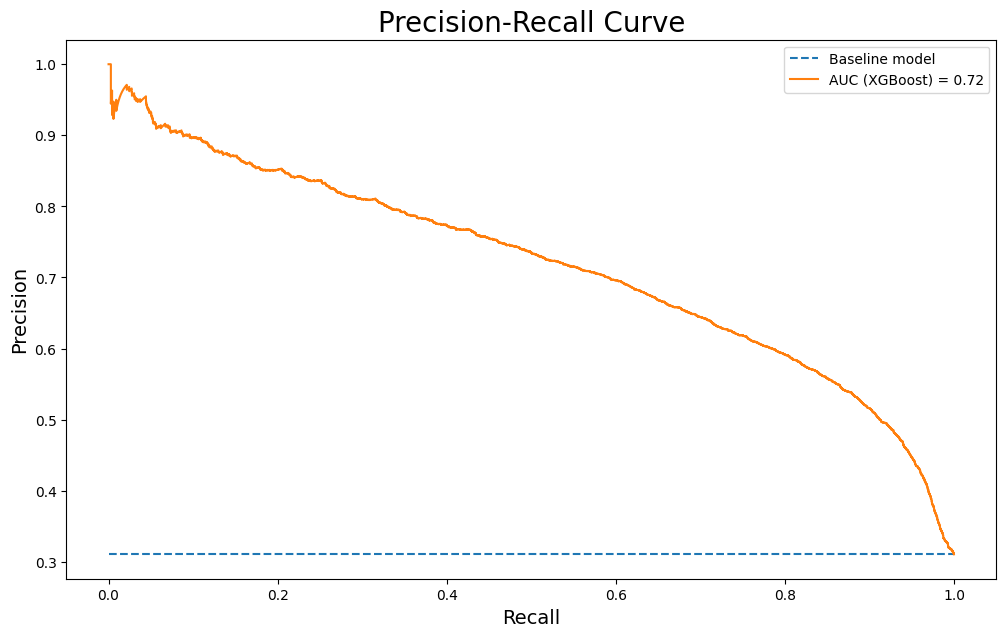

In [187]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')
plt.plot(recall_xgc, precision_xgc, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();

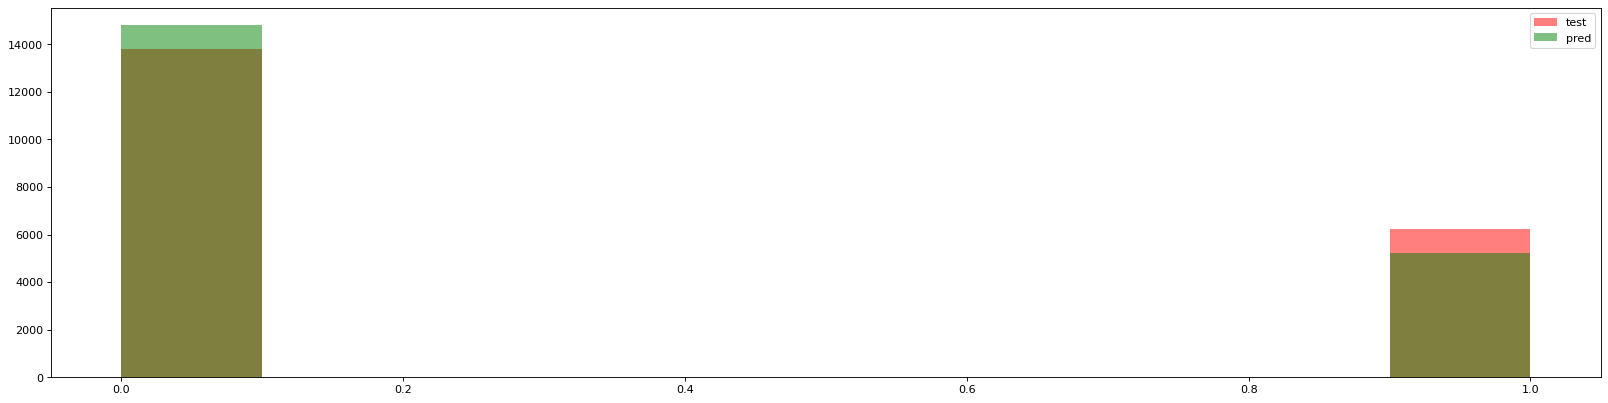

In [109]:
figure(figsize=(25, 6), dpi=80)
plt.hist(y_test_3_encoded, label = 'test', color = 'r', alpha= 0.5)
plt.hist(y_pred_3_encoded, label = 'pred', color= 'g', alpha= 0.5)
#plt.xlim([0, 200])
plt.legend()

In [194]:
from imblearn.over_sampling import SMOTE
X_train_3_resampled, y_train_3_resampled = SMOTE().fit_resample(X_train_3_opt, y_train_3_encoded)

In [196]:
model_XGBC_3_SMOTE = xgb.XGBClassifier(objective= 'binary:logistic', max_depth= 3, eval_metric= 'aucpr')
model_XGBC_3_SMOTE.fit(X_train_3_resampled, y_train_3_resampled)
y_pred_XGBC_3_SMOTE = model_XGBC_3_SMOTE.predict(X_test_3_opt)
model_XGBC_3_SMOTE.score(X_test_3_opt, y_test_3_encoded)

0.7855

In [197]:
precision = precision_score(y_test_3_encoded, y_pred_XGBC_3_SMOTE, average='binary')
print('Precision: %.3f' % precision)
recall = recall_score(y_test_3_encoded, y_pred_XGBC_3_SMOTE, average='binary')
print('Recall: %.3f' % recall)

Precision: 0.658
Recall: 0.647


In [95]:
grid_XGBC_3 = {'objective': ['reg:logistic'],
        'min_child_weight': [1, 10],
        'gamma': [6, 15],
        'subsample': [0.5, 0.6],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4]
        }
# Instanciate Grid Search
search_XGBC_3 = GridSearchCV(model_XGBC_3, grid_XGBC_3, scoring='accuracy', n_jobs = -1, cv = 2)
# Fit data to Grid Search
search_XGBC_3.fit(X_train_3_opt, y_train_3_encoded)
print(search_XGBC_3.best_estimator_)
print(search_XGBC_3.best_score_)
print(search_XGBC_3.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=6, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='reg:logistic',
              predictor='auto', ...)
0.79745
{'colsample_bytree': 0.6, 'gamma': 6, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'reg:logistic', 'subsample': 0.6}


In [42]:
y_log_3_train_opt = np.log(y_train_3_opt)
y_log_3_test_opt = np.log(y_test_3_opt)

In [49]:
model_xgb_3 = xgb.XGBRegressor(booster= 'dart', objective ='reg:absoluteerror', n_estimators = 750, learning_rate= 0.01,
                               min_child_weight= 4, max_depth= 8, colsample_bytree= 0.7, n_jobs=-1, eval_metric = 'mae')
model_xgb_3.fit(X_train_3_opt, y_log_3_train_opt)
y_pred_3_xgb = model_xgb_3.predict(X_test_3_opt)
np.exp(mean_absolute_error(y_log_3_test_opt, y_pred_3_xgb))

2.5217095456124268

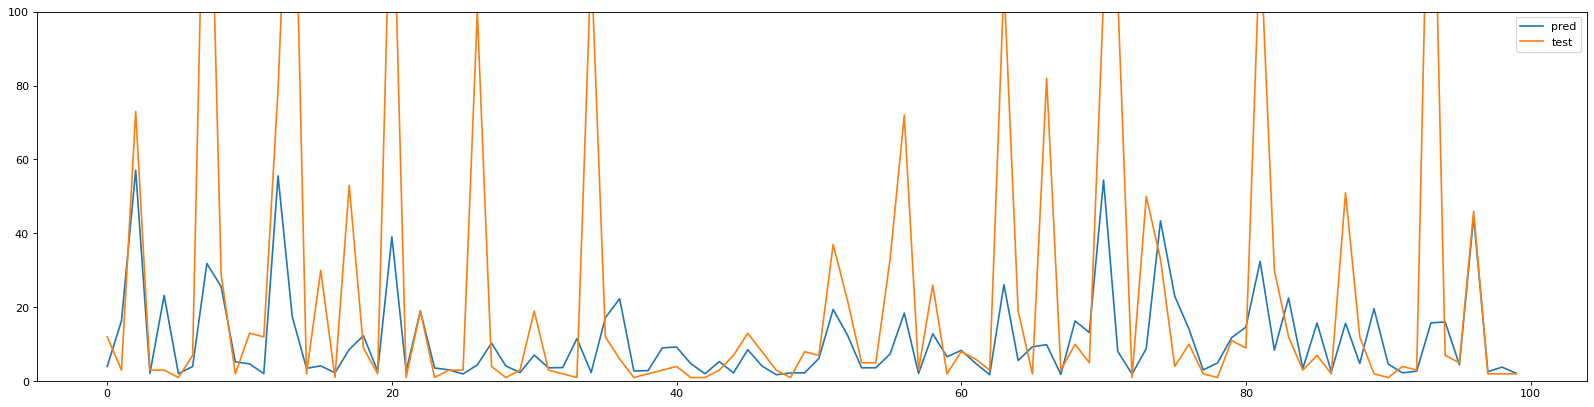

In [59]:
figure(figsize=(25, 6), dpi=80)
plt.plot(np.exp(y_pred_3_xgb[1000:1100]), label = 'pred')
plt.plot(np.array(y_test_3_opt)[1000:1100], label = 'test')
plt.ylim([0, 100])
plt.legend()

In [70]:
y_test_3_opt

48647     7
9308      7
50884     1
1473      2
48244     4
         ..
23996     6
9617      3
48181    34
4633      3
48299     3
Name: duracion_baja, Length: 20000, dtype: int64

In [69]:
np.exp(y_pred_3_xgb)

array([13.364204 , 13.8113365,  3.3695273, ..., 12.367645 ,  6.45409  ,
        4.1544814], dtype=float32)

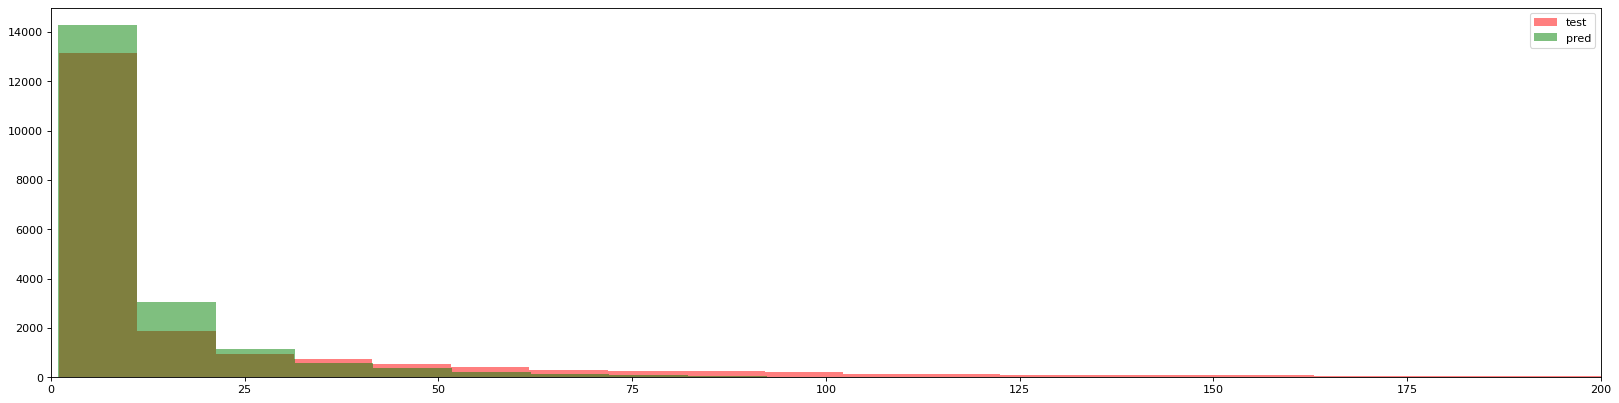

In [82]:
figure(figsize=(25, 6), dpi=80)
plt.hist(np.array(y_test_3_opt), label = 'test', bins = 58, color = 'r', alpha= 0.5)
plt.hist(np.exp(y_pred_3_xgb), label = 'pred', bins = 25, color= 'g', alpha= 0.5)
plt.xlim([0, 200])
plt.legend()

In [31]:
data_dmatrix = xgb.DMatrix(data=X_train_3_opt,label=y_log_3_train_opt)
params = {'booster': 'dart','objective':'reg:absoluteerror','eval_metric':'mae',
          'eta':0.01,'subsample':0.1}
xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'mae',seed=42) 
np.exp(xgb_cv)

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,3.458465,1.001884,3.458756,1.007739
1,3.449430,1.001899,3.449981,1.007691
2,3.440783,1.001841,3.441561,1.007710
3,3.431887,1.001820,3.432913,1.007650
4,3.423268,1.001808,3.424486,1.007615
5,3.414595,1.001773,3.416107,1.007565
6,3.406073,1.001758,3.407881,1.007527
7,3.397408,1.001742,3.399501,1.007486
8,3.388827,1.001691,3.391113,1.007482
9,3.380449,1.001727,3.382888,1.007424


In [33]:

XGB_val_mae = np.exp(cross_val_score(model_xgb_3, X_train_3_opt, y_log_3_train_opt, scoring='neg_mean_absolute_error', cv=2).mean()*(-1))
XGB_test_mae = np.exp(mean_absolute_error(y_log_3_test_opt, y_pred_3_xgb))

print(f'Validation mae= {np.round(XGB_val_mae, 2)}, test mae= {np.round(XGB_test_mae, 2)}')

Validation mae= 2.41, test mae= 2.41


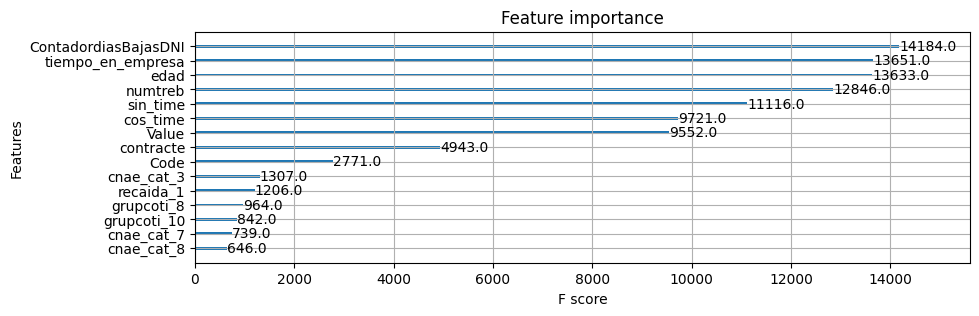

In [178]:
# plt.figure(figsize=(25,15))
plt.rcParams["figure.figsize"] = (10,3)
xgb.plot_importance(model_xgb_3, max_num_features=15)
plt.show()

In [48]:
cv_results_xgb_3 = cross_validate(model_xgb_3, X_train_3_opt, y_log_3_train_opt, cv=2,
                            scoring=['r2', 'neg_mean_absolute_error']) 
xgb_3_val_mae = np.exp(cv_results_xgb_3['test_neg_mean_absolute_error'].mean()*(-1))
xgb_3_val_r2 = cv_results_xgb_3['test_r2'].mean()
# xgb_3_test_mae = np.exp(mean_absolute_error(y_log_3_test_opt, y_pred_RF, squared = False))

print(f'Validation R2= {np.round(xgb_3_val_r2, 2)}, validation mae= {np.round(xgb_3_val_mae, 2)}')#, and testing mae= {np.round(xgb_3_test_mae, 2)}')

Validation R2= 0.43, validation mae= 2.42


In [ ]:
grid = pd.DataFrame({'eta':[0.01,0.05,0.1]*2,
'subsample':np.repeat([0.1,0.3],3)})

def fit(x):
    params = {'objective':'reg:absoluteerror',
              'eval_metric':'mae',
              'eta':x[0],
              'subsample':x[1]}
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, 
    nfold=5, metrics = 'logloss',seed=42)
    return xgb_cv[-1:].values[0]

grid[['train-mae-mean','train-mae-std',
      'test-maes-mean','test-mae-std']] = grid.apply(fit,axis=1,result_type='expand')

In [4]:

X_train = pd.read_csv('../raw_data/X_train', delimiter = ',', low_memory = False)
y_train = pd.read_csv('../raw_data/y_train', delimiter = ',', low_memory = False)
X_test = pd.read_csv('../raw_data/X_test', delimiter = ',', low_memory = False)
y_test = pd.read_csv('../raw_data/y_test', delimiter = ',', low_memory = False)

In [21]:
y_train

,duracion_baja
0,4
1,53
2,7
3,4
4,27
...,...
181327,7
181328,1
181329,26
181330,1


In [8]:
import pickle

In [9]:
def y_encode_2(y):
    if y<=15:
        return 0
    else:
        return 1

In [11]:
y_train_encoded = y_train.copy()
y_train_encoded['duracion_baja'] = y_train['duracion_baja'].map(y_encode_2)
y_test_encoded = y_test.copy()
y_test_encoded['duracion_baja'] = y_test['duracion_baja'].map(y_encode_2)

In [12]:
LOCAL_REGISTRY_PATH = os.path.expanduser(os.environ.get("LOCAL_REGISTRY_PATH"))
reg_model_path = os.path.join(LOCAL_REGISTRY_PATH, "trained_models" + "xgb_regression_model.pkl")
with open(reg_model_path, "rb") as file:
    model_reg = pickle.load(file)
        
class_model_path = os.path.join(LOCAL_REGISTRY_PATH, "trained_models" + "xgb_classifier_model.pkl")
with open(class_model_path, "rb") as file:
    model_class = pickle.load(file)

In [13]:
y_pred_reg = np.exp(model_reg.predict(X_test))
y_pred_reg

array([ 8.086987 ,  3.4446018, 13.452205 , ..., 10.727723 ,  2.8601696,
        5.514429 ], dtype=float32)

In [18]:
y_pred_class = model_class.predict(X_test)
y_pred_class

array([0, 0, 0, ..., 1, 0, 0])

In [20]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_test_encoded, y_pred_class, average='binary')
print('Precision: %.3f' % precision)
recall = recall_score(y_test_encoded, y_pred_class, average='binary')
print('Recall: %.3f' % recall)

Precision: 0.676
Recall: 0.589


In [4]:
data = pd.read_csv('../raw_data/datos.csv', delimiter = ';', low_memory = False)

In [5]:
data_interf = data.drop(columns = ['ContadorBajasCCC', 'ContadorBajasDNI', 'sexo', 'mes_baja', 'duracion_baja'])

In [6]:
data.loc[0:0]

,ContadorBajasCCC,ContadorBajasDNI,sexo,cnae,icd9,recaida,numtreb,codipostal,ContadordiasBajasDNI,contracte,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,duracion_baja,mes_baja,epiweek
0,17664,30,2,5110,009.3,0,3187,08037,224,420,2,0,7,0.51,27.2,2,12,51


In [7]:
X_new = data_interf.loc[0:0]

In [8]:
X_new

,cnae,icd9,recaida,numtreb,codipostal,ContadordiasBajasDNI,contracte,grupcoti,pluriempleo,diasemana,tiempo_en_empresa,edad,epiweek
0,5110,009.3,0,3187,08037,224,420,2,0,7,0.51,27.2,51


In [9]:
from smarthealing_mod.preprocessor import preprocess_new

In [10]:
from smarthealing_mod.preprocessor import preprocess_raw_data
X_train, X_test, y_train, y_test, cnae_categories, icd9_mapper = preprocess_raw_data()

/Users/jaimesoroarubio/code/jaimesoroa/smarthealing/smarthealing_mod/preprocessor.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['codipostal'] = data['codipostal'].replace('-', mf_codipostal)
/Users/jaimesoroarubio/code/jaimesoroa/smarthealing/smarthealing_mod/preprocessor.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('ContadorBajasDNI', axis = 1, inplace = True)
/Users/jaimesoroarubio/.pyenv/versions/3.10.6/envs/smarthealing/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer s

In [11]:
X_test

,recaida,numtreb,Code,ContadordiasBajasDNI,contracte,grupcoti,pluriempleo,tiempo_en_empresa,edad,cnae_cat,Value,sin_time,cos_time,icd9_cat_target
233500,0,160,1,39,130,7,0,2.89,36.2,3,22077.0,0.971596,0.236647,6
115546,0,26,2,1,200,5,0,0.74,26.1,18,23790.0,0.886729,0.462289,5
237149,1,313,1,27,189,9,0,2.47,24.3,7,42485.0,0.999985,-0.005494,7
67582,0,55,1,1,189,5,0,1.28,30.1,7,21345.0,-0.739332,0.673342,3
51710,0,165,4,83,189,9,0,4.30,41.7,3,21220.0,0.359737,0.933054,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11186,0,1128,1,5,289,6,0,0.25,18.8,9,22240.0,0.974754,0.223279,2
43990,0,211,1,1,189,8,0,13.80,44.3,3,22240.0,-0.364858,-0.931063,6
236847,0,1,1,3,100,8,0,1.38,32.3,8,25326.0,0.993036,0.117809,6
93499,0,51,1,8,289,8,0,3.98,38.1,18,31355.0,0.753951,0.656931,4


In [12]:
from smarthealing_mod.preprocessor import fit_pipelines

In [13]:
preproc = fit_pipelines(X_train, y_train)

In [14]:
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['ContadordiasBajasDNI',
                                                   'numtreb',
                                                   'tiempo_en_empresa']),
                                                 ('standardscaler',
                                                  StandardScaler(), ['edad']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['grupcoti', 'recaida',
                                                   'pluriempleo', 'cnae_cat',
                                                   'icd9_cat_target'])]))])

In [15]:
X_new_1 = preprocess_new(X_new, cnae_categories, icd9_mapper)
X_new_1

,recaida,numtreb,Code,ContadordiasBajasDNI,contracte,grupcoti,pluriempleo,tiempo_en_empresa,edad,cnae_cat,icd9_cat_target,Value,sin_time,cos_time
0,0,3187,1,224,420,2,0,0.51,27.2,8,2,35989,-0.223279,0.974754


In [16]:
X_new_preproc = preproc.transform(X_new_1)
X_new_preproc

array([[3.559322033898305, 22.347517730496453, -0.29490022172949004,
        -1.053575837636842, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '1', '420', 35989,
        -0.22327934252861395, 0.9747544999639601]], dtype=object)

In [16]:
LOCAL_REGISTRY_PATH = os.path.expanduser(os.environ.get("LOCAL_REGISTRY_PATH"))

In [17]:
model = xgb.XGBRegressor(booster= 'dart', objective ='reg:absoluteerror', n_estimators = 750, learning_rate= 0.01,
                             min_child_weight= 4, max_depth= 8, colsample_bytree= 0.7, n_jobs=-1, eval_metric = 'mae')

In [18]:
X_train_samp = X_train.sample(n = 100, random_state = 8)
y_train_samp = y_train.sample(n = 100, random_state = 8)

In [22]:
X_train_model = preproc.transform(X_train_samp)

In [23]:
X_train_model

array([[2.152542372881356, 0.05673758865248227, 0.7361419068736142, ...,
        22077.0, -0.24464687018361214, -0.969612246678724],
       [1.2542372881355932, 1.049645390070922, 0.5365853658536586, ...,
        22240.0, 0.24730971351828987, 0.9689364817156496],
       [0.03389830508474576, -0.07092198581560284, -0.35033259423503327,
        ..., 22240.0, 0.11235101253669214, -0.9936685815612668],
       ...,
       [-0.13559322033898305, 1.2411347517730495, -0.38137472283813756,
        ..., 20910.0, 0.47442520288330126, 0.8802958178187253],
       [0.576271186440678, -0.24822695035460993, 1.1951219512195124, ...,
        22240.0, 0.9735129828797886, 0.228631739188802],
       [-0.22033898305084745, -0.24822695035460993, -0.328159645232816,
        ..., 22077.0, 0.6589999728400661, -0.7521429623394692]],
      dtype=object)

In [17]:
def y_encode_2(y):
        if y<15:
            return 0
        else:
            return 1

In [29]:
y_train_encoded = y_train_samp.map(y_encode_2)

In [30]:
y_train_encoded

84241     1
24262     1
117979    0
44505     0
73844     0
         ..
126027    0
71522     0
61407     0
123872    1
39157     1
Name: duracion_baja, Length: 100, dtype: int64

In [20]:
model.fit(X_train_model, y_train_samp)

XGBRegressor(base_score=4.0, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=750, n_jobs=-1,
             num_parallel_tree=1, objective='reg:absoluteerror',
             predictor='auto', ...)

In [32]:
model.predict(X_new_preproc)

array([1.2985077], dtype=float32)

In [ ]:
# API

In [62]:
from datetime import datetime
import numpy as np
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import pandas as pd
import os
from smarthealing_mod.preprocessor import preprocess_new
import pickle

In [18]:
LOCAL_REGISTRY_PATH = os.path.expanduser(os.environ.get("LOCAL_REGISTRY_PATH"))


def load_models():
    '''
    persist trained model, params and metrics
    '''
        
    reg_model_path = os.path.join(LOCAL_REGISTRY_PATH, "xgb_regression_model.pkl")
    with open(reg_model_path, "rb") as file:
        model_reg = pickle.load(file)
        
    class_model_path = os.path.join(LOCAL_REGISTRY_PATH, "xgb_classifier_model.pkl")
    with open(class_model_path, "rb") as file:
        model_class = pickle.load(file)
    
    return model_reg, model_class

model_reg, model_class = load_models()



def load_files():
    # Load cnae_categories 
    cnae_categories_path = os.path.join(LOCAL_REGISTRY_PATH, "cnae_categories.pkl")
    with open(cnae_categories_path, "rb") as file:
        cnae_categories = pickle.load(file)

    # Load icd9_mapper
    icd9_mapper_path = os.path.join(LOCAL_REGISTRY_PATH, "icd9_mapper.pkl")
    with open(icd9_mapper_path, "rb") as file:
        icd9_mapper = pickle.load(file)
        
    # Load preprocessor
    preproc_path = os.path.join(LOCAL_REGISTRY_PATH, "preproc_pipeline.pkl")
    with open(preproc_path, "rb") as file:
        preproc = pickle.load(file)

    """
    # Load regressor pipeline
    regressor_path = os.path.join(LOCAL_REGISTRY_PATH, "regressor_pipeline.pkl")
    with open(regressor_path, "rb") as file:
        regressor_pipeline = pickle.load(file)

    # Load classifier pipeline
    classifier_path = os.path.join(LOCAL_REGISTRY_PATH, "classifier_pipeline.pkl")
    with open(classifier_path, "rb") as file:
        classifier_pipeline = pickle.load(file)
    """

    return cnae_categories, icd9_mapper, preproc

cnae_categories, icd9_mapper, preproc = load_files()

In [41]:
X_new_1 = preprocess_new(X_new, cnae_categories, icd9_mapper)
X_new_preproc = preproc.transform(X_new_1)
    
y_pred_reg = np.exp(model_reg.predict(X_new_preproc))
y_pred_class = model_class.predict(X_new_preproc)

In [20]:
X_train_prep = preproc.transform(X_train)
X_test_prep = preproc.transform(X_test)

In [21]:
y_pred_reg = np.exp(model_reg.predict(X_test_prep))

In [118]:
y_pred_list = list(y_pred_reg)

In [107]:
df_y_pred_reg = pd.DataFrame(y_pred_reg)
df_y_pred_reg.isnull().sum()

0    0
dtype: int64

In [117]:
y_test_list = list(y_test)

In [119]:
reg_df = pd.DataFrame(columns=['Prediction', 'Test'])

In [120]:
reg_df['Prediction'] = y_pred_list
reg_df['Test'] = y_test_list

In [121]:
reg_df

,Prediction,Test
0,8.017342,47
1,3.506008,5
2,13.537440,8
3,1.985112,3
4,52.335903,262
...,...,...
62213,1.841089,1
62214,10.407502,5
62215,10.220370,19
62216,2.781159,1


In [23]:
y_pred_class = model_class.predict(X_test_prep)

In [25]:
y_test_class = y_test.map(y_encode_2)

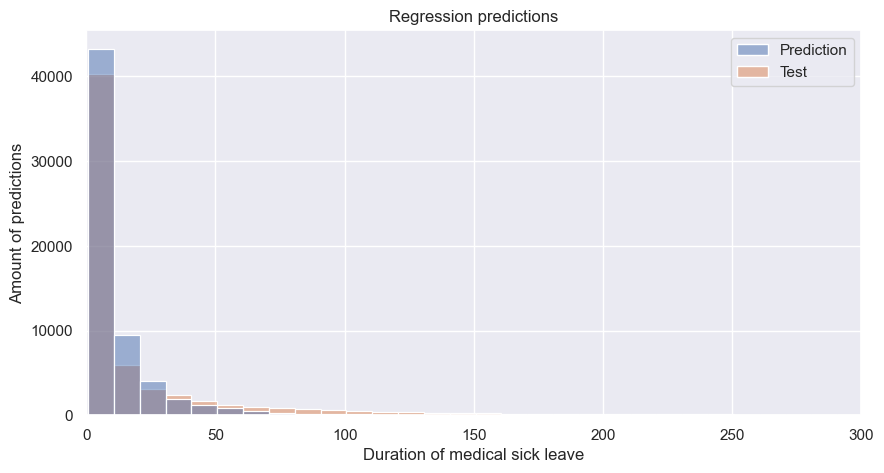

In [125]:
fig, ax = plt.subplots()

# sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data = reg_df, ax = ax, binwidth = 10, legend = True)
# sns.histplot(y_test, ax = ax, binwidth = 10, legend = True)
 
# This will change the limits of the x-axis
ax.set_xlim(0, 300)

# This will change the limits of the y-axis
#ax.set_xlim(0, 50000)
 
# This will add label to the X-axis
ax.set_xlabel( "Duration of medical sick leave")
 
# This will add label to the Y-axis
ax.set_ylabel( "Amount of predictions")
 
# This will add title to the plot
ax.set_title( "Regression predictions")

legend = ax.get_legend()
handles = legend.legendHandles
# legend.remove()
ax.legend(handles, ['Prediction', 'Test'])#, 'ind+', 'dep+'], title='Stat.ind.')

plt.show()

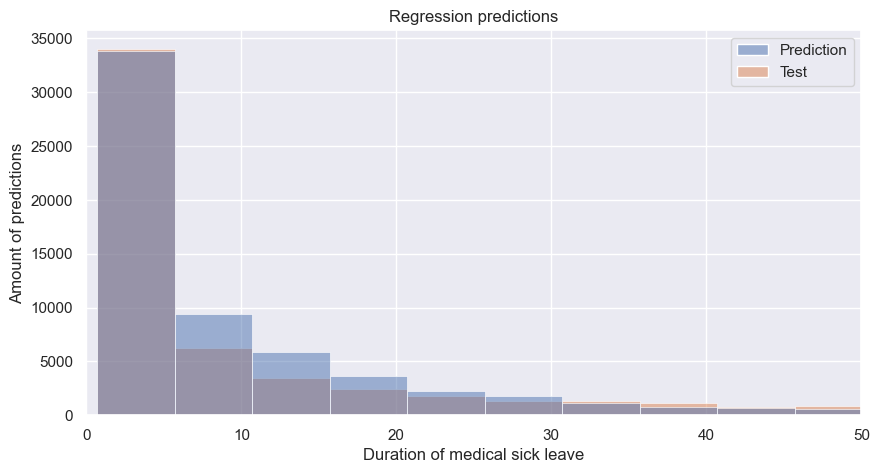

In [127]:
fig, ax = plt.subplots()

# sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data = reg_df, ax = ax, binwidth = 5, legend = True)
# sns.histplot(y_test, ax = ax, binwidth = 10, legend = True)
 
# This will change the limits of the x-axis
ax.set_xlim(0, 50)

# This will change the limits of the y-axis
#ax.set_xlim(0, 50000)
 
# This will add label to the X-axis
ax.set_xlabel( "Duration of medical sick leave")
 
# This will add label to the Y-axis
ax.set_ylabel( "Amount of predictions")
 
# This will add title to the plot
ax.set_title( "Regression predictions")

legend = ax.get_legend()
handles = legend.legendHandles
# legend.remove()
ax.legend(handles, ['Prediction', 'Test'])#, 'ind+', 'dep+'], title='Stat.ind.')

plt.show()

In [128]:
class_df = pd.DataFrame(columns=['Prediction', 'Test'])

In [129]:
class_df['Prediction'] = list(y_pred_class)
class_df['Test'] = list(y_test_class)

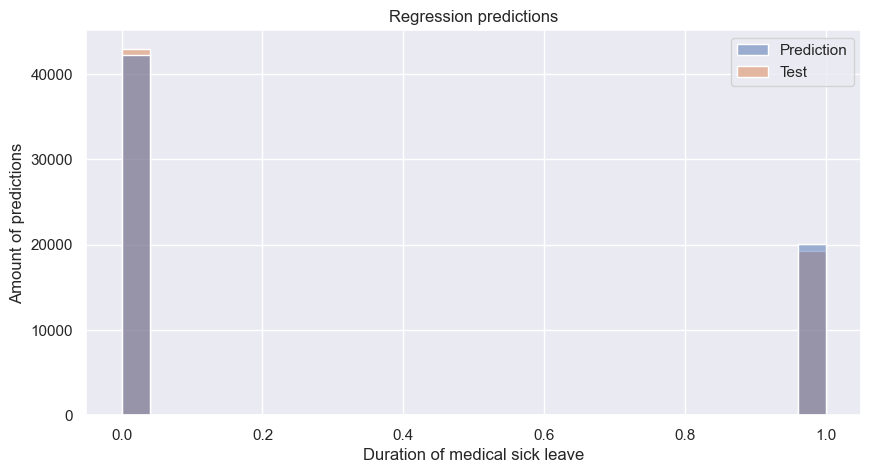

In [136]:
fig, ax = plt.subplots()

# sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data = class_df, ax = ax, legend = True)
# sns.histplot(y_test, ax = ax, binwidth = 10, legend = True)
 
# This will change the limits of the x-axis
# ax.set_xlim(0, 50)

# This will change the limits of the y-axis
#ax.set_xlim(0, 50000)
 
# This will add label to the X-axis
ax.set_xlabel( "Duration of medical sick leave")
 
# This will add label to the Y-axis
ax.set_ylabel( "Amount of predictions")
 
# This will add title to the plot
ax.set_title( "Regression predictions")

legend = ax.get_legend()
handles = legend.legendHandles
# legend.remove()
ax.legend(handles, ['Prediction', 'Test'])#, 'ind+', 'dep+'], title='Stat.ind.')

plt.show()

<AxesSubplot: >

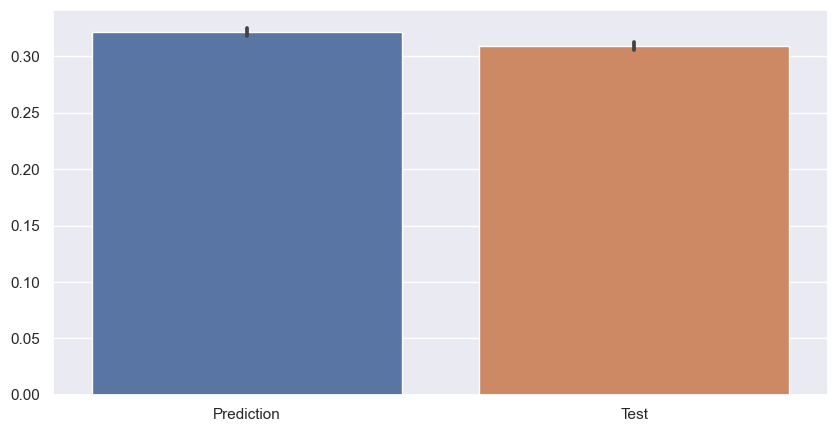

In [137]:
sns.barplot(data = class_df)

<AxesSubplot: xlabel='duracion_baja', ylabel='Count'>

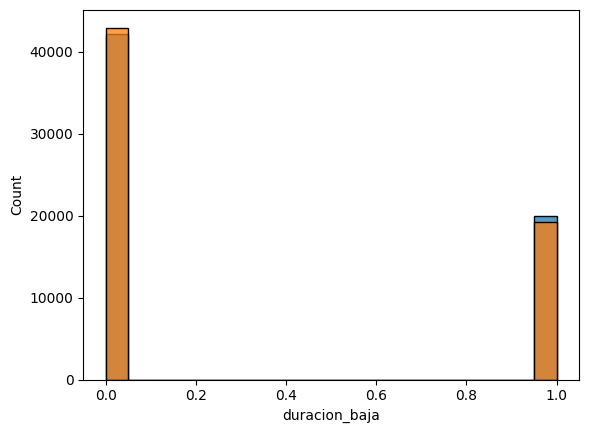

In [90]:
sns.histplot(y_pred_class)
sns.histplot(y_test_class)